In [115]:
# Import the n

In [116]:
from osgeo import gdal
import geopandas as gdp
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble, model_selection

## Data info 
Following data are used in this exersize
- Raste Data : Landsat 8 data 
    We are using the stack images given in the folder data/LC08_L1TP_146039_20211229_20220106_01_T1
    -- LC08_L1TP_146039_20211229_20220106_01_T1_stack.tif 
        has 12 bands in the order (B1,B2,B3,B4,B5,B6,B7,B9,B10,B11,BQA). We will use the seven bands from B1-7 in this exersise.
- Vector data : 100 Sample points generate using the QGIS. 
   It contains the attributes 
   -- rand_point : Id of the random point generated
   -- Class : Integer represeting the classes (1:Snow/Clouds, 2:Waste Land , 3:Forest , 4: , 5: )

In [117]:
img_path="/Users/ashutosh/Documents/GitHub/IIRSOUTREACHPROGRAMME-2022-AIEO/data/LC08_L1TP_146039_20211229_20220106_01_T1/LC08_L1TP_146039_20211229_20220106_01_T1_stack.tif"
point_path='/Users/ashutosh/Documents/GitHub/IIRSOUTREACHPROGRAMME-2022-AIEO/data/ClassPoints/rPoints/rPoints.shp'

In [118]:
ds=gdal.Open(img_path)
trans=ds.GetGeoTransform()
data=ds.ReadAsArray()


In [119]:
data.shape 

(12, 7911, 7771)

## Do the subsetting


In [120]:
data=data[0:7,:,:]
data.shape

(7, 7911, 7771)

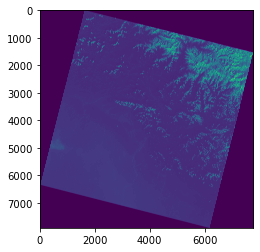

In [121]:
data.shape
plt.imshow(data[1]) #plot the sencon basdn

Text(0, 0.5, 'Band DN Value')

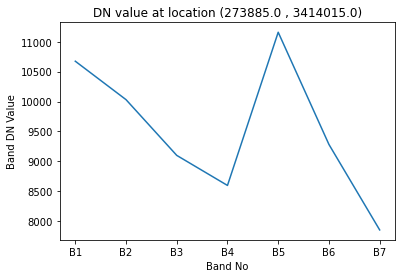

In [134]:
fig, ax = plt.subplots()
ax.plot(data[:,5000,2000]) #Check the seven bands details at location 5000,2000
trans=ds.GetGeoTransform()
Xloc = trans[1] * 5000 + trans[2] * 2000 + trans[0];
Yloc = trans[4] * 5000 + trans[5] * 2000 + trans[3];
ax.set_xticks([0, 1, 2 ,3 , 4 , 5 ,6])
labels=ax.set_xticklabels(['B1', 'B2', 'B3', 'B4', 'B5', 'B6','B7'])
ax.set_title(f"DN value at location ({Xloc} , {Yloc})")
ax.set_xlabel("Band No")
ax.set_ylabel("Band DN Value")

In [135]:
df=gdp.read_file(point_path)

To get the sample value of points at location(lat,long) we need to use the following formula
- point.lon-raster.orgin.lon)/pixelsize
- point.lat-raster.orgin.lat)/pixelsize


In [148]:
print(trans)

(123885.0, 30.0, 0.0, 3474015.0, 0.0, -30.0)


In [166]:
def GetVal(X): #The function implements the above formual
    lon=X.geometry.x
    lat=X.geometry.y
    r=int((trans[3]-lat)/trans[1])
    c=int((trans[0]-lon)/trans[5])
    return data[k,r,c]

In [167]:
noOfBands,_,_=data.shape #Get the number of bands in the data sets
print(noOfBands)
for k in range(0,noOfBands): #Get the bands values at sample location
    df["b"+str(k+1)]=df.apply(GetVal,axis='columns')

7


In [168]:
df.head(3) #Print the details of data 

,rand_point,Class,Name,geometry,b1,b2,b3,b4,b5,b6,b7
0,0.0,5,None,POINT (164348.531 3287250.117),9960,9246,8421,7802,11066,8888,7115
1,1.0,3,None,POINT (223821.523 3459977.914),8316,7832,7459,7513,11449,11812,9366
2,2.0,2,None,POINT (242196.037 3449017.659),9496,8596,7267,6625,6530,5227,5200


## Prepare the feautures and target 
For random Forest classfication from the sample points features and targets are created

In [169]:
print(target)

[5 3 2 3 3 2 3 3 3 5 5 3 5 3 3 4 5 5 1 1 5 3 6 3 3 3 5 3 3 3 5 3 5 3 3 3 3
 1 3 3 5 3 3 1 3 4 3 3 5 3 3 3 3 3 3 1 5 5 5 1 3 4 5 3 3 3 5 3 5 3 1 5 5 3
 3 5 3 5 5 3 3 5 3 2 3 1 3 5 5 3 1 5 1 3 5 2 3 3 3 1]


In [170]:
feature=df[['b1','b2','b3','b4','b5','b6','b7']].values #For sample point locatin  a feature vector contains the 
#informaion of only bands DN values
target=df['Class'].values #The class target label is subset

In [171]:
target.shape #Confirm there are 100 sampel points

(100,)

## Setup the random forest classfier 
The number of trees in the forest is set 100. The maximum depth of the tree is set to the number of each feature constituent which is 7(no of columns in feature vectors).The minimum number of samples required to split an internal node:is set to 4. The split criterion is set to default ("gini").The number of jobs to run in parallel for exploiting the multiprocessor cores of machine.Random_state is set to 1. It controls both the randomness of the bootstrapping of the samples used when building trees. For details of parameter refer to [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [172]:
forest=ensemble.RandomForestClassifier(n_estimators=100,  
                                      min_samples_split=4,
                                      max_depth=7,
                                      random_state=1,
                                      n_jobs=-1)

In [173]:
forest=forest.fit(feature,target)

In [174]:
print(forest.score(feature,target)) #Testing with same data. Cautions this will be biased. You willneed 

0.94


Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

In [175]:
print(forest.feature_importances_)
pram_rang=np.arange(1,250,10)

[0.1989581  0.20054647 0.20688492 0.17979748 0.07584667 0.06703845
 0.0709279 ]


In [176]:
from sklearn.model_selection import validation_curve

## Validation steps
Validation curves carry outs the hyperparamter search.Here are using to get the tranning scores.The details can be found at [link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html)

In [177]:
train_score,test_score=validation_curve(forest,feature,target,
                                        param_name='n_estimators',
                                        param_range=pram_rang,
                                        cv=3,
                                        scoring='accuracy',
                                        n_jobs=-1) 

/Users/ashutosh/opt/anaconda3/envs/eoai/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


In [178]:
test_mean=np.mean(test_score,axis=1)
train_mean=np.mean(train_score,axis=1)

In [179]:
print(test_mean)
print(train_mean)

[0.75995247 0.84076055 0.85056447 0.84046346 0.84046346 0.84046346
 0.84046346 0.84046346 0.84046346 0.84046346 0.84046346 0.84046346
 0.84046346 0.84046346 0.84046346 0.84046346 0.84046346 0.84046346
 0.83065954 0.83065954 0.83065954 0.83065954 0.83065954 0.83065954
 0.83065954]
[0.86024423 0.94512287 0.935248   0.94014775 0.93517262 0.94512287
 0.95009799 0.94504749 0.95009799 0.95002261 0.94504749 0.94504749
 0.94504749 0.95009799 0.94504749 0.93509724 0.94007237 0.95002261
 0.94504749 0.94504749 0.95002261 0.95009799 0.94504749 0.95009799
 0.95009799]


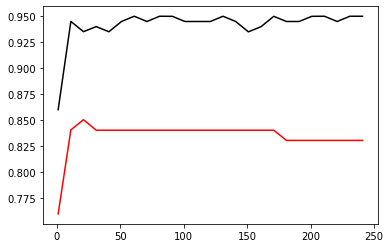

In [180]:
plt.plot(pram_rang,test_mean,label="CV_Score", color='red')
plt.plot(pram_rang,train_mean,label="Tranning Score",color='black')

# Checking a sample of forest

In [181]:
sample=np.array([8587,8031,7542,7427,13455,11577,8731]).reshape(1,-1)
forest.predict(sample)

array([3])

# Applying for all pixel of image

In [182]:
ouputdata=np.zeros((7911,7771)) #Data place to keep the classifed image data

In [ ]:
for r in range(7911):
    print(f'processing row {r}')
    for c in range(7771):
        pred=data[:,r,c].reshape(1,-1)
        ouputdata[r,c]=forest.predict(pred)

In [ ]:
plt.imshow(ouputdata)